# 3. Paralelismo em Julia: @threads e @spawn

## Contexto 

Julia oferece diversas opções para o programador desenvolver paralelismo na linguagem, em diversos estágios de desenvolvimento:
  - Multithreading
  - Pacote Distributed: https://docs.julialang.org/en/v1/manual/distributed-computing/
  - Wrappers para MPI: https://juliaparallel.github.io/MPI.jl/stable/
  - GPU em Julia: https://juliagpu.org/
  
Neste minicurso nós abordaremos as capacidades de multithreading do Julia, implementável através das macros de paralelização. O multithreading em Julia tem poucos recursos, e em 2019 teve novas funcionalidades adicionadas à linguagem, em especial thread safe I/O, scheduling dinâmico e uma macro nova, @spawn. Para mais informações sobre as adições de 2019: https://julialang.org/blog/2019/07/multithreading/
   
\* No Julia, até o presente momento, não é possível alterar a quantidade de threads em tempo de execução. Caso queira conhecer como configurar a quantidade de threads em Julia, veja o notebook 5 deste minicurso sobre como configurar o ambiente para multithreading.

## @threads for loops

A macro @threads é uma macro usada para paralelismo de dados. Ela é utilizada para loops e divide a região onde será feita a paralelização das operações entre as threads disponíveis. O modelo atual de @threads em Julia funciona com a divisão da área de iteração do loop em tarefas. Essas tarefas são enviadas para um scheduler, que 
com ajuda de chamadas a implementações em C, realiza a divisão da região do vetor/matriz. No caso do @threads o scheduling é estático, e a quantidade de iterações em cada thread é igual, independente da carga de trabalho de desse loop.

In [3]:
using BenchmarkTools
using Base.Threads
using Plots

In [4]:
@which Threads.@threads
# para mais informações sobre a macro 

@threads(__source__::LineNumberNode, __module__::Module, args...) in Base.Threads at threadingconstructs.jl:118

In [5]:
matrix = zeros(Int64, 10, 10)
@threads for i in 1:length(matrix)
    matrix[i] = threadid()
end
matrix

10×10 Array{Int64,2}:
 1  1  1  2  2  3  3  3  4  4
 1  1  1  2  2  3  3  3  4  4
 1  1  1  2  2  3  3  3  4  4
 1  1  1  2  2  3  3  3  4  4
 1  1  1  2  2  3  3  3  4  4
 1  1  2  2  2  3  3  4  4  4
 1  1  2  2  2  3  3  4  4  4
 1  1  2  2  2  3  3  4  4  4
 1  1  2  2  2  3  3  4  4  4
 1  1  2  2  2  3  3  4  4  4

Da mesma forma, poderíamos usar 

In [6]:
@threads for i in 1:nthreads()
    sleep(threadid())
    println("thread ",threadid()," done sleeping")
end

thread 1 done sleeping
thread 2 done sleeping
thread 3 done sleeping
thread 4 done sleeping


Para exemplificação do uso de @threads, vamos utilizar um exemplo de redução. Vamos reduzir os valores de um array de n posições a um único valor.

In [7]:
a = rand(10_000_000);

In [8]:
function baseline_sum(arr)
    result::eltype(arr) = zero(eltype(arr))
    for i in arr
        result += i
    end
    return result
end
baseline_sum(a)

4.999779204063732e6

In [9]:
metric = median(@benchmark baseline_sum(a))

BenchmarkTools.TrialEstimate: 
  time:             13.543 ms
  gctime:           0.000 ns (0.00%)
  memory:           16 bytes
  allocs:           1

Vamos colocar os valores de benchmarking da mediana em um dicionário para criar um gráfico ao final da experiência com as funções utilizadas.

In [39]:
dict = Dict{String, Float64}()
push!(dict, "bl_sum"=> metric.time/10e5)

Dict{String,Float64} with 1 entry:
  "bl_sum" => 13.5426

# @threads

In [11]:
function threaded_sum(arr)
    results = zeros(eltype(arr), nthreads())
    @threads for id in 1:nthreads()             #@threads gera um closure
        acc = zero(eltype(arr))                 #cada thread tem um acc localmente 
        len = div(length(arr), nthreads())      
        domain = ((id-1)*len+1):id*len          #cada thread trabalha 1/nthreads() do array
        for i in domain          
            acc += arr[i]
        end
        results[id] = acc                       #cada soma parcial é posta em uma variável no escopo acima
    end
    sum(results)                                #soma os resultados
end

threaded_sum (generic function with 1 method)

Como, neste exemplo específico estamos lidando com operações de ponto flutuante, a ordem das operações importa, e portanto, ao paralelizarmos o código, podemos ter resultados diferentes, o que não significa que o resultado esteja incorreto.

In [12]:
threaded_sum(a) ==  baseline_sum(a)

false

In [13]:

threaded_sum(a) ≈ baseline_sum(a)

true

In [40]:
metric_threaded_sum = median(@benchmark threaded_sum(a));
push!(dict, "threaded_sum"=> metric_threaded_sum.time/10e5)

Dict{String,Float64} with 2 entries:
  "bl_sum"       => 13.5426
  "threaded_sum" => 5.71744

É claro que, quando lidamos com um acesso à memória compartilhada, é preciso com data race e false sharing. Nenhuma macro vai cuidar disso, é preciso construir os algoritmos para evitar que data races e false sharings aconteçam.

In [15]:
function naive_sum(arr)
    total = zero(eltype(arr))
    @threads for i in arr
        total += i
    end
    return total
end

naive_sum (generic function with 1 method)

In [16]:
naive_sum(a)

1.2519880364103669e6

In [17]:
naive_sum(a) ≈ baseline_sum(a)

false

In [18]:
function false_sharing_sum(arr)
    partial = zeros(eltype(a), nthreads())
    @threads for i in 1:length(a)
        partial[threadid()] += arr[i]
    end
    sum(partial)
end

false_sharing_sum (generic function with 1 method)

In [19]:
false_sharing_sum(a) ≈ baseline_sum(a)

true

In [41]:
metric_fs_sum = median(@benchmark false_sharing_sum(a));
push!(dict, "fs_sum"=> metric_fs_sum.time/10e5)

Dict{String,Float64} with 3 entries:
  "bl_sum"       => 13.5426
  "threaded_sum" => 5.71744
  "fs_sum"       => 16.1652

## Atomics e Locks

Julia possui um conjunto de operações atômicas disponíveis, que podem ser usadas em situações em que é necessário assegurar acesso a uma região crítica Operações atômicas e de Lock são extremamente caras, então é aconselhável usá-las o mínimo possível para não comprometer performance.

In [21]:
function naive_atomic_sum(arr)
    total = Atomic{eltype(arr)}(0)
    acc = zero(eltype(arr))
    @threads for i in 1:length(arr)
        atomic_add!(total, a[i])
    end
    return total[]
end

naive_atomic_sum (generic function with 1 method)

In [22]:
naive_atomic_sum(a) ≈ baseline_sum(a)

true

In [23]:
@btime naive_atomic_sum(a)

  568.015 ms (19999514 allocations: 305.17 MiB)


4.9997792040632395e6

In [24]:
# exemplo de função utilizando atomic
function sum_thread_atomic(A)
   r = Atomic{eltype(A)}(zero(eltype(A)))
   len, rem = divrem(length(A), nthreads()) #calcula a divisão do array
   @threads for t in 1:nthreads()
      partial = zero(eltype(A))
      for i in (1:len) .+ (t-1)*len
         partial += A[i]
      end
      atomic_add!(r, partial)
    end
   result = r[]
   #processa os dados restantes
   for i in length(A)-rem+1:length(A)
      result += A[i]
   end
   return result
end

sum_thread_atomic (generic function with 1 method)

In [25]:
sum_thread_atomic(a) ≈ baseline_sum(a)

true

In [42]:
metric_atomic = median(@benchmark sum_thread_atomic(a));
push!(dict, "at_sum"=> metric_atomic.time/10e5)

Dict{String,Float64} with 4 entries:
  "bl_sum"       => 13.5426
  "at_sum"       => 5.73623
  "threaded_sum" => 5.71744
  "fs_sum"       => 16.1652

## Lock

In [28]:
#exemplo de função utilizando locks 
function sum_thread_lock(A)
    result = zero(eltype(A))
    cond = ReentrantLock()
    len, rem = divrem(length(A), nthreads())
    @threads for t in 1:nthreads()
        partial = zero(eltype(A))
        for i in (1:len) .+ (t-1)*len
             partial += A[i]
        end
        lock(cond)
        result += partial
        unlock(cond)
    end
    for i in length(A)-rem+1:length(A)
        result += A[i]
    end
    return result
end

sum_thread_lock (generic function with 1 method)

In [29]:
sum_thread_lock(a) ≈ baseline_sum(a)

true

In [43]:
metric_lock = median(@benchmark sum_thread_lock(a));
push!(dict, "lck_sum" => metric_lock.time/10e5)

Dict{String,Float64} with 5 entries:
  "bl_sum"       => 13.5426
  "lck_sum"      => 5.71574
  "at_sum"       => 5.73623
  "threaded_sum" => 5.71744
  "fs_sum"       => 16.1652

**Utilizando a macro inbounds**

In [31]:
function inbounds_mt_sum(arr)
    results = zeros(eltype(arr), nthreads())    #cria um vetor estático
    @threads for id in 1:nthreads()             #@threads gera um closure
        acc = zero(eltype(arr))                 #cada thread tem um acc localmente 
        len = div(length(arr), nthreads())      
        domain = ((id-1)*len+1):id*len          #cada thread trabalha 1/nthreads() do array
        for i in domain          
            @inbounds acc += arr[i]             #omite a checagem de borda
        end
        results[id] = acc                           #cada soma parcial é posta em uma variável no escopo acima
    end
    sum(results)                                #soma os resultados
end

inbounds_mt_sum (generic function with 1 method)

In [32]:
inbounds_mt_sum(a) ≈ baseline_sum(a)

true

In [46]:
metric_inbounds = median(@benchmark inbounds_mt_sum(a));
push!(dict, "ib_sum"=> metric_inbounds.time/10e5)

Dict{String,Float64} with 6 entries:
  "bl_sum"       => 13.5426
  "ib_sum"       => 5.69841
  "lck_sum"      => 5.71574
  "at_sum"       => 5.73623
  "threaded_sum" => 5.71744
  "fs_sum"       => 16.1652

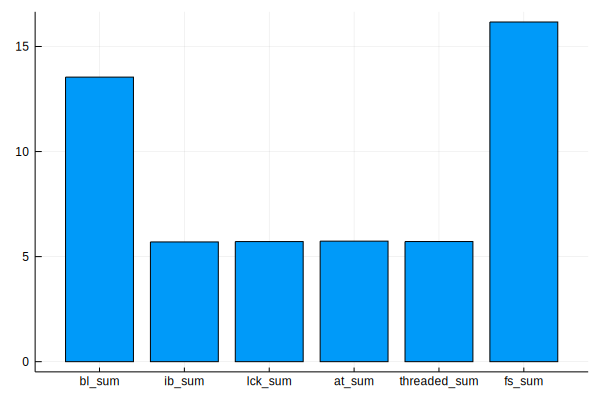

In [47]:
plt = bar!(dict, legend=false)

# @spawn

@spawn é a nova macro que foi adicionada em 2019, e se destina a paralelismo de tarefas. Ao contrário do @threads, que tem um conjunto de iterações associado a uma tarefa que ocorre em cada thread. @spawn realiza o scheduling dinâmico de tarefas.

Para entender como funciona uma tarefa...

In [ ]:
import Base.Threads.@spawn

In [48]:
function task_spawn()
    for i = 1:10
        @spawn println(threadid())
    end
end
task_spawn()

LoadError: LoadError: UndefVarError: @spawn not defined
in expression starting at In[48]:3

In [ ]:
function spawn_sum!(A::Vector{Float64}, lo, hi)
    if lo == hi
        return A[lo]
    end
    mid = (hi + lo + 1) >> 1
    leftsum = @spawn spawn_sum!(A, lo, mid-1)
    rigthsum = @spawn spawn_sum!(A, mid, hi)
    return fetch(leftsum) + fetch(rigthsum)
end

In [ ]:
@btime spawn_sum!(a, 1, length(a))

In [ ]:
@btime baseline_sum(a)